In [ ]:
! pip install opencv tqdm numpy torch matplotlib

In [1]:
import os
import cv2
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torch.optim as optim
import torch.nn as nn

from PIL import Image

import matplotlib.pyplot as plt

# FDDB Parsing

In [2]:
# Paths
dataset_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\images"
labels_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\label.txt"

# Target resolution
TARGET_HEIGHT, TARGET_WIDTH = 1080, 1920

# Define all alignments
alignments = [
    "top_left", "top_middle", "top_right",
    "center_left", "center_middle", "center_right",
    "bottom_left", "bottom_middle", "bottom_right"
]

def parse_labels(label_path):
    """ Reads the label file and returns a dictionary mapping image paths to bounding boxes. """
    labels = {}
    with open(label_path, 'r') as f:
        lines = f.readlines()
        image_path = None
        for line in lines:
            line = line.strip()
            if line.startswith("#"):
                image_path = line[2:]  # Remove '# '
                labels[image_path] = []
            else:
                labels[image_path].append(list(map(int, line.split())))
    return labels

def pad_image(image, bboxes, alignment="middle_middle"):
    """ Applies padding to fit the image into a 1920x1080 frame while aligning it as specified. """
    orig_h, orig_w, _ = image.shape

    # Compute padding required
    padding_x = TARGET_WIDTH - orig_w
    padding_y = TARGET_HEIGHT - orig_h

    if "top" in alignment:
        top, bottom = 0, padding_y
    elif "center" in alignment:
        top, bottom = padding_y // 2 , padding_y - (padding_y // 2)
    elif "bottom" in alignment:  # bottom
        top, bottom = padding_y, 0
    else:
        raise RuntimeError("y change not specified")

    if "left" in alignment:
        left, right = 0, padding_x
    elif "middle" in alignment:
        left, right = padding_x // 2, padding_x - (padding_x // 2)
    elif "right" in alignment:  # right
        left, right = padding_x, 0
    else:
        raise RuntimeError("x change not specified")

    # Apply padding
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Update bounding boxes
    updated_bboxes = []
    for (x_min, y_min, x_max, y_max) in bboxes:
        x_min, x_max = x_min + left, x_max + left
        y_min, y_max = y_min + top, y_max + top
        updated_bboxes.append([x_min, y_min, x_max, y_max])

    return padded_image, updated_bboxes

# FDDB Pre-Processing
We need to pre-process be the images are not 1080p while the webcam is. So we will add padding (so we don't scale and mess with resolution or box numbers) to create 3 versions (left, right, and middle padding).

In [3]:
output_image_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\aug_images"
output_labels_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\aug_label.txt"

# Ensure output directory exists
os.makedirs(output_image_path, exist_ok=True)

with open(output_labels_path, "w") as new_label_file:
    labels = parse_labels(labels_path)
    total_images = len(labels) * len(alignments)  # Total processing steps

    # Initialize tqdm progress bar
    with tqdm(total=total_images, desc="Processing Images", unit="img") as pbar:
        for img_rel_path, bboxes in labels.items():
            img_abs_path = os.path.join(dataset_path, img_rel_path)

            # Load image
            image = cv2.imread(img_abs_path)
            if image is None:
                print(f"Warning: Could not read {img_rel_path}")
                continue

            # Process all 9 alignments
            base_name = os.path.splitext(os.path.basename(img_rel_path))[0]  # Extract image filename without extension
            for alignment in alignments:
                padded_image, updated_bboxes = pad_image(image, bboxes, alignment=alignment)

                # Save new image with updated name
                new_img_name = f"{base_name}_{alignment}.jpg"
                new_img_path = os.path.join(output_image_path, new_img_name)
                cv2.imwrite(new_img_path, padded_image)

                # Write new labels
                rel_img_path = os.path.relpath(new_img_path, output_image_path)
                new_label_file.write(f"# {rel_img_path}\n")
                for bbox in updated_bboxes:
                    new_label_file.write(" ".join(map(str, bbox)) + "\n")
                
                # Update progress bar
                pbar.update(1)


Processing Images: 100%|██████████| 25515/25515 [02:53<00:00, 146.87img/s]


# Prep Dataset for Use

In [4]:
class FaceDataset(Dataset):
    def __init__(self, images_folder, labels_file, transform = None):
        self.images_folder = images_folder
        self.transform = transform # technically should be a parameter, but due to situation, we are doing that seperately beforehand
        self.data = []

        with open(labels_file, "r") as f:
            lines = f.readlines()
            image_path = None
            boxes = []
            for line in lines:
                line = line.strip()
                if line.startswith("#"):
                    if image_path:  # Save previous image
                        self.data.append((image_path, boxes))
                    image_path = os.path.join(images_folder, line[2:])
                    boxes = []
                else:
                    boxes.append(list(map(int, line.split())))
            if image_path:  # Save last image
                self.data.append((image_path, boxes))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, boxes = self.data[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = Image.open(image).convert('RGB')

        # keep in for easy refactor in the future
        if self.transform:
            image = self.transform(image)

        # # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0,1]

        # Convert bounding boxes to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Labels (assuming all objects belong to class 1, since it's face detection)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        return image, target

In [5]:
full_images_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\aug_images"
full_labels_path = r"C:\PROJECTS\MILO\MILO\FaceRecognition\data\Dataset_FDDB\aug_label.txt"
dataset = FaceDataset(full_images_path, full_labels_path)

train_size = int(0.8 * len(dataset))

indices = torch.randperm(len(dataset)).tolist()
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model Training

## SSDLite

In [26]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights, ssdlite
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator
import math

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load SSD300 with VGG16 backbone
model = ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)  # Set to True if you want pretrained weights
model.to(device)

# Get the number of input features for the classification head
in_channels = [list(m.parameters())[0].shape[0] for m in model.head.classification_head.module_list]

# Check input channels
num_anchors = model.head.classification_head.module_list[0][1].out_channels // 91  # Default COCO classes is 91

dummy_input = torch.randn(1, 3, 1080, 1920).to(device)
features = model.backbone(dummy_input)
feature_map_shapes = [f.shape[-2:] for f in features.values()]

def get_new_anchor_generator(input_size, feature_map_shapes, aspect_ratios=None):
    num_feature_maps = len(feature_map_shapes)
    # Define relative scales (as fractions) for the anchor boxes.
    # We compute num_feature_maps+1 scales.
    s_min, s_max = 0.2, 0.9
    scales = [s_min + (s_max - s_min) * k / num_feature_maps for k in range(num_feature_maps + 1)]
    
    if aspect_ratios is None:
        # For each feature map, use a default set of aspect ratios.
        aspect_ratios = [[1.0, 2.0, 0.5]] * num_feature_maps
    
    # Now create the DefaultBoxGenerator with the computed scales (a list of floats)
    anchor_generator = DefaultBoxGenerator(aspect_ratios, scales=scales)
    return anchor_generator

# For example, using the height (1080) as the reference:
new_anchor_generator = get_new_anchor_generator(1080, feature_map_shapes)
# Replace the model's anchor generator:
model.anchor_generator = new_anchor_generator


# Modify classification head to have 2 classes 
model.head.classification_head.num_classes = 2  # Update class count
model.head.classification_head = ssdlite.SSDLiteClassificationHead(
    in_channels = in_channels,
    num_anchors = [num_anchors], 
    num_classes = 2,
    norm_layer = nn.BatchNorm2d
)


# Modify for 1080p Input
model.size = (1080, 1920)

# Freeze all layers by default
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the first few layers of the backbone
for layer in list(model.backbone.features)[:1]:  # Modify the number as needed
    for param in layer.parameters():
        param.requires_grad = True

# Unfreeze the last layers of the detection head (classification + box regression)
for param in model.head.classification_head.parameters():
    param.requires_grad = True

# for param in model.head.regression_head.parameters():
#     param.requires_grad = True

# Print which layers are trainable
trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable layers:", trainable_layers)


# Define Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


Trainable layers: ['backbone.features.0.0.0.weight', 'backbone.features.0.0.1.weight', 'backbone.features.0.0.1.bias', 'backbone.features.0.1.block.0.0.weight', 'backbone.features.0.1.block.0.1.weight', 'backbone.features.0.1.block.0.1.bias', 'backbone.features.0.1.block.1.0.weight', 'backbone.features.0.1.block.1.1.weight', 'backbone.features.0.1.block.1.1.bias', 'backbone.features.0.2.block.0.0.weight', 'backbone.features.0.2.block.0.1.weight', 'backbone.features.0.2.block.0.1.bias', 'backbone.features.0.2.block.1.0.weight', 'backbone.features.0.2.block.1.1.weight', 'backbone.features.0.2.block.1.1.bias', 'backbone.features.0.2.block.2.0.weight', 'backbone.features.0.2.block.2.1.weight', 'backbone.features.0.2.block.2.1.bias', 'backbone.features.0.3.block.0.0.weight', 'backbone.features.0.3.block.0.1.weight', 'backbone.features.0.3.block.0.1.bias', 'backbone.features.0.3.block.1.0.weight', 'backbone.features.0.3.block.1.1.weight', 'backbone.features.0.3.block.1.1.bias', 'backbone.fea

In [20]:
# Initialize lists to store losses
train_losses = []
eval_losses = []

# Live plotting function
def plot_losses():
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(eval_losses, label="Eval Loss", marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Evaluation Loss")
    plt.legend()
    plt.grid()
    plt.show(block=False)
    plt.pause(0.1)  # Pause to update the plot

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training Loop with tqdm & Live Graph
def train_model(model, train_loader, test_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        # tqdm progress bar for training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for images, targets in progress_bar:
            optimizer.zero_grad()
            # Move data to GPU if available
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            outputs = model(images, targets)

            # Compute loss
            # loss = criterion(outputs, targets)
            loss = sum(loss for loss in outputs.values())
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate Model After Each Epoch
        avg_eval_loss = evaluate_model(model, test_loader)
        eval_losses.append(avg_eval_loss)

        # Print Epoch Summary
        print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Eval Loss = {avg_eval_loss:.4f}")


# Evaluation Function with tqdm Progress Bar
def evaluate_model(model, test_loader):
    model.train()
    total_loss = 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", unit="batch")
        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # When targets are provided, the model returns a dictionary of losses.
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(test_loader)
    return avg_loss

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


Evaluating: 100%|██████████| 1276/1276 [01:33<00:00, 13.61batch/s, loss=6.2087] 



Epoch 1: Train Loss = 4.8785, Eval Loss = 5.1220


Evaluating: 100%|██████████| 1276/1276 [01:33<00:00, 13.69batch/s, loss=5.7227] 



Epoch 2: Train Loss = 4.8353, Eval Loss = 5.1167


Evaluating: 100%|██████████| 1276/1276 [01:33<00:00, 13.67batch/s, loss=5.5830] 



Epoch 3: Train Loss = 4.7988, Eval Loss = 5.1265


Evaluating: 100%|██████████| 1276/1276 [01:33<00:00, 13.58batch/s, loss=5.6772] 



Epoch 4: Train Loss = 4.7692, Eval Loss = 5.1105


Evaluating: 100%|██████████| 1276/1276 [01:33<00:00, 13.65batch/s, loss=5.5626] 



Epoch 5: Train Loss = 4.7302, Eval Loss = 5.1213


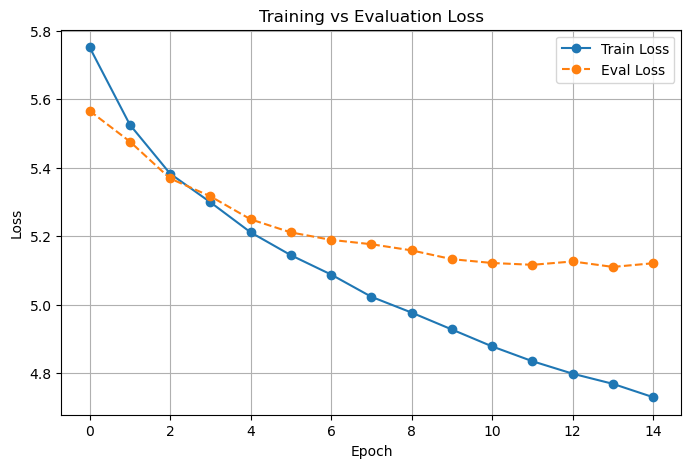

In [18]:
print(device)
model.to(device)
for _ in range(1):
    # Train Model with Evaluation Each Epoch
    train_model(model, train_loader, test_loader, num_epochs=5)
    plot_losses()
    torch.save(model.state_dict(), r"C:\PROJECTS\MILO\MILO\FaceRecognition\model.pth")
    

In [ ]:
# Convert to ONNX with 1080p Input
dummy_input = torch.randn(1, 3, 1080, 1920).to(device)  # Adjusted for 1080p
torch.onnx.export(model, dummy_input, ["ssd_1080p.onnx"], dynamo=True)

In [10]:
torch.save(model.state_dict(), r"C:\PROJECTS\MILO\MILO\FaceRecognition\model.pth")

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()